[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp451/blob/master/NaiveBayes.ipynb)
# Naive Bayes
In Naive Bayes, we learn:
- a *prior* for the probability of each class by counting relative frequency of class labels in the dataset.
    - for multi-class classification, wich $C$ classes, this is a categorical distribution $\mathrm{Categorical}(y=c_0; \pi) = \prod_c \pi_c^{\mathbb{I}(y=c)} = \pi_{c_0}$. MLE is given by $\pi_c = \frac{N(y=c)}{N}$.
- a probability for the value of each feature $x_d$, conditioned on the class label $y$. The type of this probability distribution depends on the feature type. In this notebook, we only consider the **Gaussian** distribution: $p(x_d| y=c, \mathcal{D}) = \mathcal{N}(x_d; \mu_{d,c}, \sigma_{d,c})$. The maximum likelihood is given by the empirical mean and variance of feature $x_d$ for instances belonging to class $c$.

Once we learn both the class prior $p(y)$ and class conditionals $p(x_d|y)$ from the data, we can use the Bayes rule to calculate posterior class probability
$p(y| x) \propto p(y) p(x| y)$. 

For maximum likelihood estimates see the [previous notebook](maximumLikelihood.ipynb)

In [5]:
import numpy as np
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import datasets
np.random.seed(1234)

## Fitting the data
Below, first we implement the `fit` function that learns the model parameters. We use *Laplace smoothing* for the class prior using $\alpha=\beta=1$ (i.e., what we called add-one smoothing in the class).

Following `scikit-learn` For any new classification or regression method, we use the same structure -- that is we have a class with `fit` and `predict` functions.

In [6]:

class GaussianNaiveBayes:
    
    def __init__(self):
        return
    
    def fit(self, x, y, C=None):
        N, D = x.shape
        if C is None:
            C = np.max(y) + 1
        # one parameter for each feature conditioned on each class
        mu, sigma = np.zeros((C,D)), np.zeros((C,D))
        Nc = np.zeros(C) # will store number of instances in each class 
        # for each class get the MLE for the mean and variance
        for c in range(C):
            x_c = x[y == c]                           
            Nc[c] = x_c.shape[0]                      
            mu[c,:] = np.mean(x_c,0)                  
            sigma[c,:] = np.std(x_c, 0)               
            
        self.mu = mu                                  # C x D
        self.sigma = sigma                            # C x D
        self.pi = (Nc+1)/(N+C)                        # add-one smoothing
        return self

## Prediction for new data
So far we have produced model parameters. To calculate the posterior for new instances, we need to evaluate
$$
\tilde{p}(y=c| x) = \mathrm{Categorical}(c; \pi) \prod_{d} \mathcal{N}(x_d; \mu_{d, c}, \sigma^2_{d,c})
$$
with large number of features $D$, the product will encounter a numerical problem since it can grow too large or too small.
For this reason we work in the log domain:
$$
\log \tilde{p}(y=c| x) = \log(\pi_c) +  \sum_{d} \log \left (\mathcal{N}(x_d; \mu_{d, c}, \sigma^2_{d,c}) \right)
$$
Logarithm of the Gaussian takes the following form:
$$
\log \left (\mathcal{N}(x_d; \mu_{d, c}, \sigma^2_{d,c}) \right) = -\frac{1}{2} \log(2\pi) - \log(\sigma_{d,c}) -  \frac{(x - \mu_{d,c})^2}{2\sigma_{d,c}^2}.
$$

### Normalization and numerical stability
At this point we have logarithm of **unnormalized** posterior $\log \tilde{p}(y=c| x, \mathcal{D}) \forall c$. 
To get the probabilities, we need to normalize. We can do this in the log domain as well:
$$
\log p(y=c|x) =  (\log \tilde{p}(y=c| x)) - \log \left (\sum_{c'} \exp (\log \tilde{p}(y=c| x)) \right )
$$
Again, this could run into numerical issues because of large numbers in the exponent inside log-sum-exp. Here, we use the **log-sum-exp** trick, which uses the fact that
$\log \sum_c \exp (z_c) = z_{max} + \log \sum_c \exp (z_c - z_{max})$.
In fact, one could replace $z_{max}$ with any constant. However, to help the numerical stability we use either min or max, so that all the values in the exponent are closer to zero.

In [7]:
def logsumexp(Z):                                                # C x N
    Zmax = np.max(Z,axis=0)[None,:]                              # max over C
    log_sum_exp = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=0))
    return log_sum_exp

def predict(self, xt): # see the formula above
    Nt, D = xt.shape
    log_prior = np.log(self.pi)[:, None]
    log_likelihood = -.5 * np.log(2*np.pi) - np.log(self.sigma[:,None,:]) -.5 * (((xt[None,:,:] - self.mu[:,None,:])/self.sigma[:,None,:])**2)
    log_likelihood = np.sum(log_likelihood, axis=2)
    # posterior calculation
    log_posterior = log_prior + log_likelihood
    posterior = np.exp(log_posterior - logsumexp(log_posterior))
    return posterior.T    # N x C

GaussianNaiveBayes.predict = predict

## Experiment
Next, we apply the model to classify the Iris dataset. As before we only use two features for better visualization. We split the dataset into train and test, and evaluate the accuracy of our model on the test data.

In [8]:
from sklearn import model_selection
x, y = datasets.load_iris(return_X_y=True)
x = x[:, :2]
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2) 
model = GaussianNaiveBayes()
model.fit(x_train, y_train)
y_prob = model.predict(x_test)
y_pred = np.argmax(y_prob, 1) # pick the label with maximum probability
accuracy = np.sum(y_pred == y_test)/y_pred.shape[0]
print(f'test accuracy: {accuracy}')

test accuracy: 0.8


## Decision boundary
Below we draw the decision boundary by producing the prediction of our model on all points on a 2D grid. These points are produced using `meshgrid` function. We see that the decision boundary is not linear.
We also mark the mean of the Gaussian for each class using a `x`.

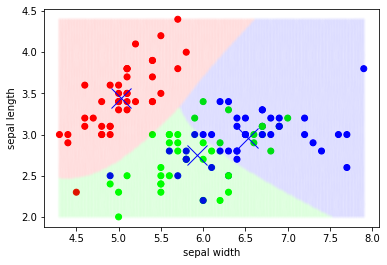

In [9]:
num_classes = np.max(y) + 1
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T
y_train_prob = np.zeros((y_train.shape[0], num_classes))
y_train_prob[np.arange(y_train.shape[0]), y_train] = 1
y_prob_all = model.fit(x_train, y_train).predict(x_all)
y_pred_all = np.zeros_like(y_prob_all)
y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, 1)] = 1
plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_all, marker='.', alpha=.01)
plt.plot(model.mu[:,0], model.mu[:,1], 'bx', markersize=20)
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.show()

### Linear decision boundary
Gaussian Naive Bayes becomes a linear classifier once we fix the variance of the Gaussian across all classes.
Below, we repeat the same code above, with the only different that the standard deviation is manually set to 1 (the value of this constant does not matter as long as it is the same across all classes, why?)

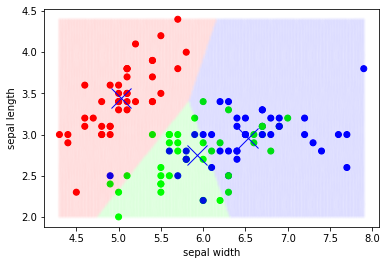

In [11]:
y_train_prob = np.zeros((y_train.shape[0], num_classes))
y_train_prob[np.arange(y_train.shape[0]), y_train] = 1
model.fit(x_train, y_train)
model.sigma[:] = 1 #fixing the standard deviations
y_prob_all = model.predict(x_all)
y_pred_all = np.zeros_like(y_prob_all)
y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, 1)] = 1
plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_all, marker='.', alpha=.01)
plt.plot(model.mu[:,0], model.mu[:,1], 'bx', markersize=20)
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.show()